# CleanLab を使ったアノテーション間違いの検出

## 準備｜ランタイムの変更

- 以下のコードを実施する前に、画面上部のメニューから `ランタイム` から `ランタイムのタイプを変更` の順にクリックし， ハードウェアアクセラレータから `GPU` を選択すること
    - 他の設定はそのままで問題ない

## ライブラリのイントール

In [1]:
# skorch : PyTorch を scikit-learn と同じインターフェースに揃えるラッパーライブラリ
# cleanlab : モデルの予測をもとにアノテーション間違い等を検出するライブラリ
!pip install -q skorch==0.13 cleanlab==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 25.3 MB/s eta 0:00:00


## ライブラリのインポート

In [2]:
# 乱数に関するライブラリ（初期値のシード固定に使用）
import random

# 配列操作に関するライブラリ
import numpy as np
# データ可視化に関するライブラリ
import matplotlib.pyplot as plt

# PyTorch 関連
import torch
from torch import (
    nn, # 層・活性化関数
    optim # 最適化アルゴリズム
)

# torchvision 関連
import torchvision
from torchvision.datasets import CIFAR10 # CIFAR-10
from torchvision.transforms import ( # 前処理・データ拡張
    Compose, # 処理をひとまとめにする
    ToTensor, # PyTorch のテンソル形式に変換
    RandomHorizontalFlip, # ランダムに左右反転
)

# skorch 関連
from skorch import NeuralNet

# ClearnLab 関連
from cleanlab.filter import find_label_issues

## データの読み込み

In [3]:
# 訓練データに対する前処理・データ拡張
train_transform = Compose([
        # 指定した確率で画像を左右反転するデータ拡張
        RandomHorizontalFlip(
            p=0.5 # 反転する確率（p = 0.5 なら 50 %）
        ), 
        # 画像を PyTorch のデータ形式に変換する
        ToTensor()
    ])

# テストデータに対する前処理
test_transform = Compose([
        # 画像を PyTorch のデータ形式に変換する
        ToTensor()
    ])

# CIFAR-10 の訓練データをダウンロード
train_dataset = CIFAR10(
                    root='.', # ダウンロードしたデータセットの保存先
                    train=True, # 訓練データを指定
                    transform=train_transform, # 画像に対する前処理・データ拡張
                    download=True # データセットのダウンロードを行う
                )

# CIFAR-10 のテストデータをダウンロード
test_dataset = CIFAR10(
                    root='.', # ダウンロードしたデータセットの保存先
                    train=False, # テストデータを指定
                    transform=test_transform, # 画像に対する前処理
                    download=True # データセットのダウンロードを行う
                )

100%|██████████| 170498071/170498071 [00:04<00:00, 40310089.59it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


## CIFAR-10 のアノテーション間違いを確認する
- https://labelerrors.com/ で指摘されているもののうち、明らかに間違いであるものを確認する

In [4]:
# ラベル名をまとめたリスト
label_list = [
    'airplane', # 飛行機
    'automobile', # 乗り物
    'bird', # 鳥
    'cat', # 猫
    'deer', # 鹿
    'dog', # 犬
    'frog', # カエル
    'horse', # 馬
    'ship', # 船
    'truck' # トラック
]

# 整数で表現されたラベルから、ラベル名に変換する関数
def label_id_to_text(
    label_id, # 整数で表現されたラベル
    label_list=label_list # ラベル名をまとめたリスト
):
    return label_list[label_id]

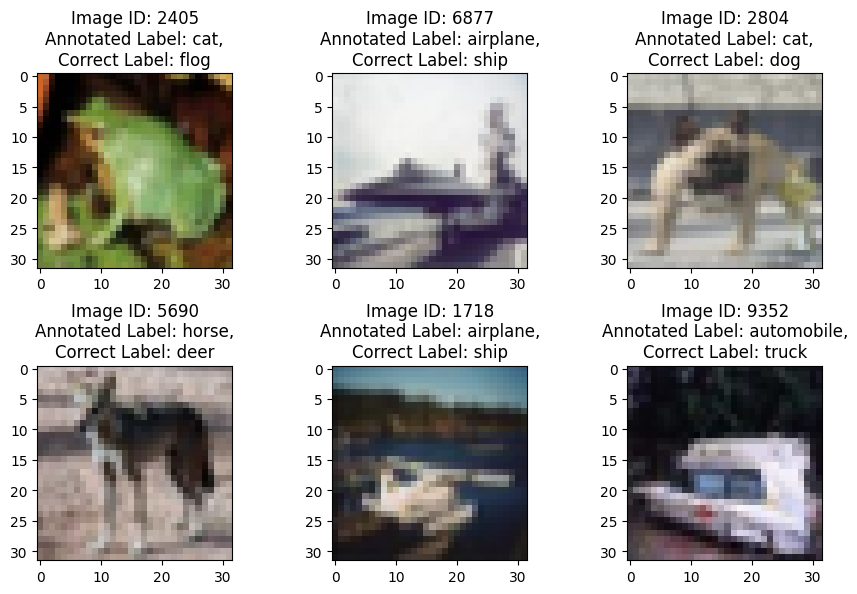

In [5]:
# テストデータに含まれる、明らかにアノテーション間違いである画像を表示する関数
def show_misannotated_image():
    # 明らかにアノテーション間違いである画像のインデックスと正しいラベルをまとめたリスト
    misannotated_img_ids_and_correct_labels = [
        (2405, 'flog'),
        (6877, 'ship'),
        (2804, 'dog'),
        (5690, 'deer'),
        (1718, 'ship'),
        (9352, 'truck')
    ]

    # 2 行 3 列の描画領域を作成（全体の大きさは横 9 インチ、縦 6 インチ）
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    # 各描画領域を 1 次元の NumPy 配列で表現する
    axes = axes.flatten()
    # 左上→右上→左下→右下の順で描画
    for i in range(len(misannotated_img_ids_and_correct_labels)):
        # 描画領域をひとつ取り出す
        ax = axes[i]
        # アノテーション間違いである画像のインデックスと正しいラベルの組をひとつ取得
        img_id, correct_label = misannotated_img_ids_and_correct_labels[i]
        # 画像とアノテーションされたラベル（整数形式）を取得
        img, label_id = test_dataset[img_id]
        # 整数で表現されたラベルを名称に変換
        annotated_label = label_id_to_text(label_id)
        # 画像を NumPy 形式に変換
        img_np = img.numpy()
        # 描画領域上部に画像 ID、アノテーションされたラベル、正しいラベルを表示
        ax.set_title(f'Image ID: {img_id}\nAnnotated Label: {annotated_label},\nCorrect Label: {correct_label}')
        # 画像を（チャンネル, 縦, 横）形式から（縦, 横, チャンネル）形式に変換した上で表示
        ax.imshow(img_np.transpose(1, 2, 0))
    # 文字等がかぶらないようにレイアウトを調整
    plt.tight_layout()

# 上記の関数を実行
show_misannotated_image()

## 事前学習済みモデルの読み込みと学習
- 今回は ImageNet 学習済み 18 層 ResNet を使用
- 全結合層だけ差し替えて学習する 

In [6]:
# ImageNet 学習済み 18 層 ResNet を定義
resnet_pretrained = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# 事前学習済みの重みをすべてフリーズ（更新させない）する
for param in resnet_pretrained.parameters():
    param.requires_grad = False

# 事前学習済みモデルの全結合層のみ差し替える(差し替えた部分は学習対象)
resnet_pretrained.fc = nn.Sequential(
    nn.LazyLinear(out_features=256), # 全結合層
    nn.ReLU(), # ReLU
    nn.LazyLinear(out_features=10), # 全結合層
)

# メッセージが表示されるが、気にしなくてよい

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
# デバイス情報を取得
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# skorch で ResNet をラップする（scikit-learnのAPIに揃える）
model = NeuralNet(
    module=resnet_pretrained, # PyTorch モデル
    criterion=nn.CrossEntropyLoss(), # 損失関数（今回はクロスエントロピー）
    optimizer=optim.Adam, # 学習アルゴリズム（今回は Adam）
    batch_size=128, # バッチサイズ（今回は 128）
    max_epochs=10, # エポック数（今回は 10）
    device=device # デバイス情報
)

In [8]:
# PyTorch の乱数部分（全結合層の初期化、ミニバッチの選択）を固定化する関数
def torch_fix_seed(
    seed=42 # シード値
):
    # Python の random モジュールの乱数を固定化
    random.seed(seed)
    # NumPy の乱数を固定化
    np.random.seed(seed)
    # PyTorch の乱数を固定化
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [9]:
# 乱数の固定化
torch_fix_seed()

# 学習を実行
model.fit(train_dataset)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        1.7898        1.6774  23.0350
      2        1.6554        1.6251  15.3287
      3        1.6322        1.6460  14.7205
      4        1.6127        1.6311  14.9382
      5        1.6043        1.6227  16.1125
      6        1.5945        1.6492  15.2583
      7        1.5911        1.6350  15.2901
      8        1.5800        1.6073  14.9271
      9        1.5819        1.6268  15.0325
     10        1.5706        1.6128  15.7964


<class 'skorch.net.NeuralNet'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mom

## 学習済みモデルの予測確率を使った、アノテーション間違い（の疑いがあるデータ）の検出

In [10]:
# テストデータに対して予測確率を取得
test_pred_probs = model.predict_proba(test_dataset)

# テストデータのラベル（整数形式）を取得
test_labels = test_dataset.targets

In [11]:
# CleanLab の find_label_issues 関数でアノテーション間違いの疑いがあるデータのインデックスを取得
ranked_label_issues = find_label_issues(
    test_labels, # ラベル
    test_pred_probs, # 予測確率
    return_indices_ranked_by="self_confidence", # 間違いの疑いが高い順にデータのインデックスを並び替えて返す
)

print(f"アノテーション間違いの疑いがあるのは {len(ranked_label_issues)} 件です")
print(f"間違いの可能性が高い順上位 15 件のインデックス: \n {ranked_label_issues[:15]}")

アノテーション間違いの疑いがあるのは 3811 件です
間違いの可能性が高い順上位 15 件のインデックス: 
 [8100  112 2494 1713 1913 5825 8757 7707 5638 8517 4702 2260 3969  779
 1693]


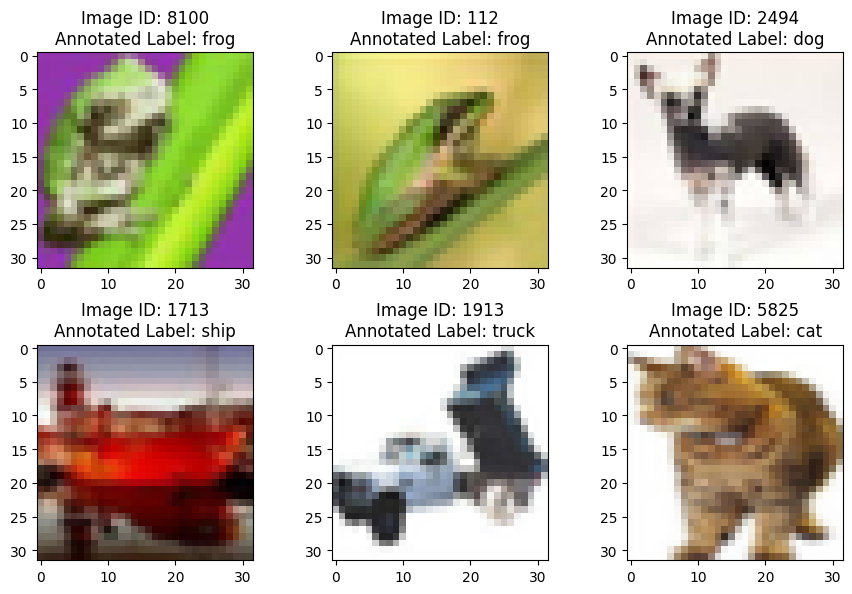

In [12]:
# 間違いの疑いが高いデータ上位 6 件を可視化する関数
def show_issued_image(
    ranked_label_issues_top6 # データのインデックス 6 件分
):
    # 2 行 3 列の描画領域を作成
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    # 描画領域を 1 次元の NumPy 配列として表現
    axes = axes.flatten()
    # 各描画領域ごとに画像等を表示
    for i in range(len(ranked_label_issues_top6)):
        # 描画領域を取得
        ax = axes[i]
        # インデックスをひとつ取得
        img_id = ranked_label_issues_top6[i]
        # インデックスに対応する画像とラベル（整数形式）を取得
        img, label_id = test_dataset[img_id]
        # ラベルを文字列の形式に変更
        annotated_label = label_id_to_text(label_id)
        # 画像を NumPy 配列に変換
        img_np = img.numpy()
        # 描画領域の上部にインデックスとラベル名を表示
        ax.set_title(f'Image ID: {img_id}\nAnnotated Label: {annotated_label}')
        # 画像を（チャンネル, 縦, 横）形式から（縦, 横, チャンネル）形式に変換してから描画
        ax.imshow(img_np.transpose(1, 2, 0))
    # 文字が重ならないようにレイアウトを調整
    plt.tight_layout()

# 間違いの疑いが高いデータ上位 6 件を可視化
show_issued_image(ranked_label_issues[:6])